In [1]:
# IMPORTACIONES Y CONFIGURACIONES INICIALES

# Importar las bibliotecas
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense,
                                     Input, Layer, Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional)
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import warnings

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [2]:
# Inicializo git y dvc (subo antes el archivo credentials.json)

!git init
!git config --global user.email "mcruzchu@gmail.com"
!git config --global user.name "Mariana Cruz"
!pip install dvc-gdrive
!apt install tree
!dvc --version
!dvc init
!dvc remote add -d storage gdrive://'1LQnbv6PF5GncWAufWu6Na_l9Aw0LKgBQ'
import json
with open("credentials.json") as f:
    os.environ["GDRIVE_CREDENTIALS_DATA"] = f.read()

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.3/445.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.6/46.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (70.7 kB/s)
Selecting previously unselected package tree.
(Reading database ... 120899 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
3.33.3
Initialized DVC repository.

You can now commit the changes to git.

+---------------------------------------------------------------------+
|                                                                     |
|        DVC has enabled anonymous aggregate usage analytics.      

Downloading...
From: https://drive.google.com/uc?id=1-3-nVKJfLry8Fi793lV_Uzvl06Sy2Svb
To: /content/DataFlickr8KDataset.zip
100%|██████████| 1.12G/1.12G [00:03<00:00, 327MB/s]


credentials.json  DataFlickr8KDataset  DataFlickr8KDataset.zip	__MACOSX  sample_data
captions.txt  Images


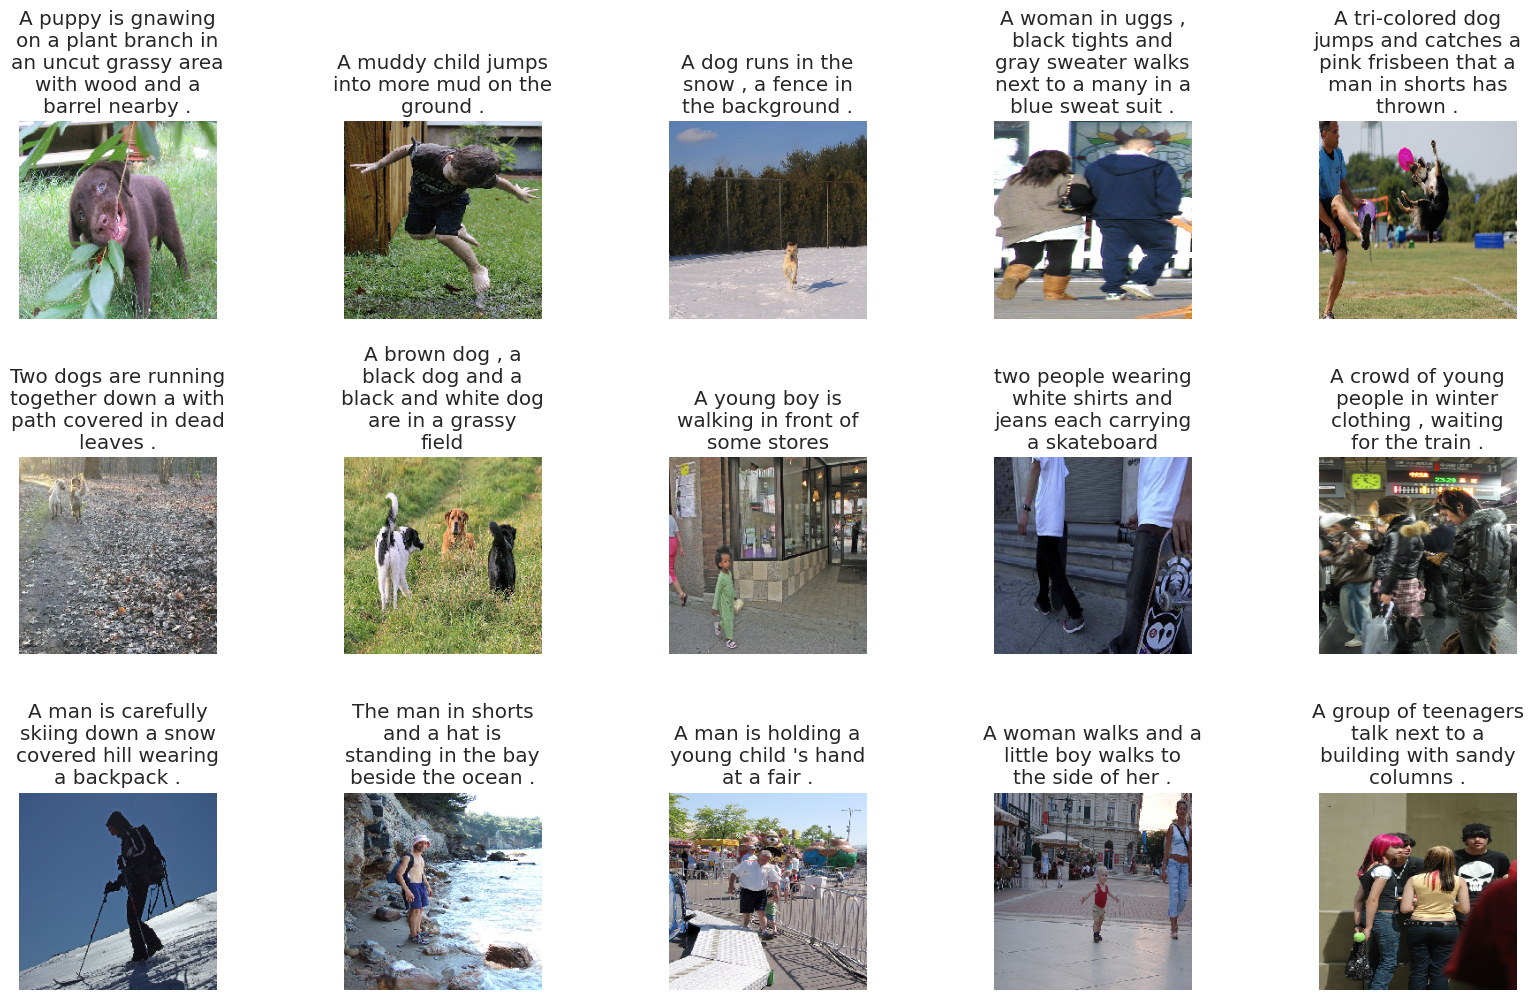

In [3]:
# CARGA DE DATOS

# Instalar y cargar gdown para descargar los datos
!pip install gdown
import gdown

# Descargar y descomprimir el conjunto de datos
url = 'https://drive.google.com/uc?id=1-3-nVKJfLry8Fi793lV_Uzvl06Sy2Svb'
gdown.download(url, 'DataFlickr8KDataset.zip', quiet=False)
!unzip -oq DataFlickr8KDataset.zip
!ls
!ls DataFlickr8KDataset

# Definir las rutas de las imágenes y los datos
image_path = './DataFlickr8KDataset/Images'
data_path = './DataFlickr8KDataset/captions.txt'

# Leer los datos
data = pd.read_csv(data_path)

# Filtrar para obtener solo el 20% de las imágenes únicas
unique_images = data['image'].unique()
selected_images = unique_images[:int(len(unique_images) * 0.20)]
data = data[data['image'].isin(selected_images)]

# Definición de funciones
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20, 20))
    n = 0
    for i in range(min(15, len(temp_df))):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(image_path + "/" + temp_df.image[i])
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

# Mostrar las imágenes seleccionadas
display_images(data.sample(min(15, len(data))))


In [ ]:
!dvc add DataFlickr8KDataset.zip
!git add DataFlickr8KDataset.zip.dvc .gitignore
!git commit -m "Agregar archivo - DVC"
!dvc push

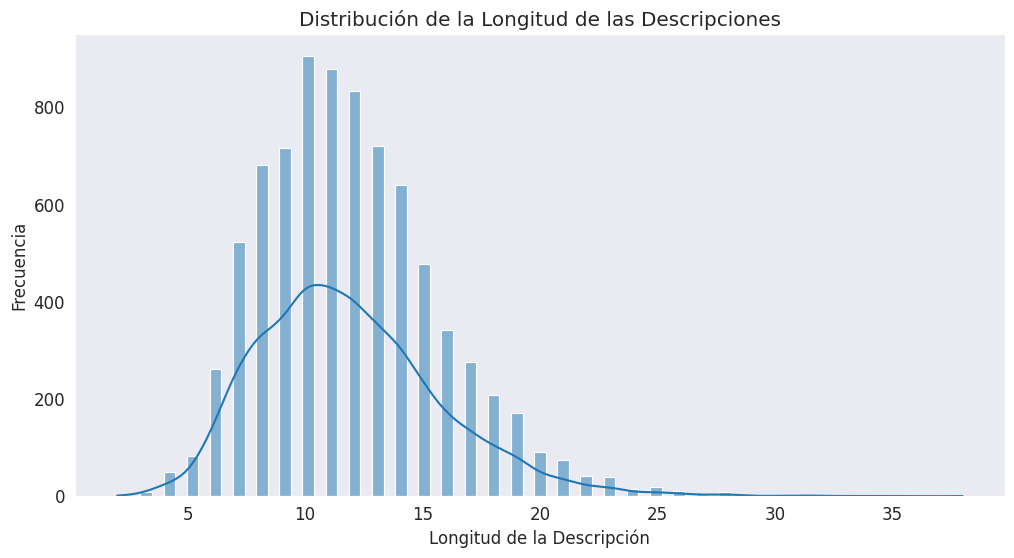

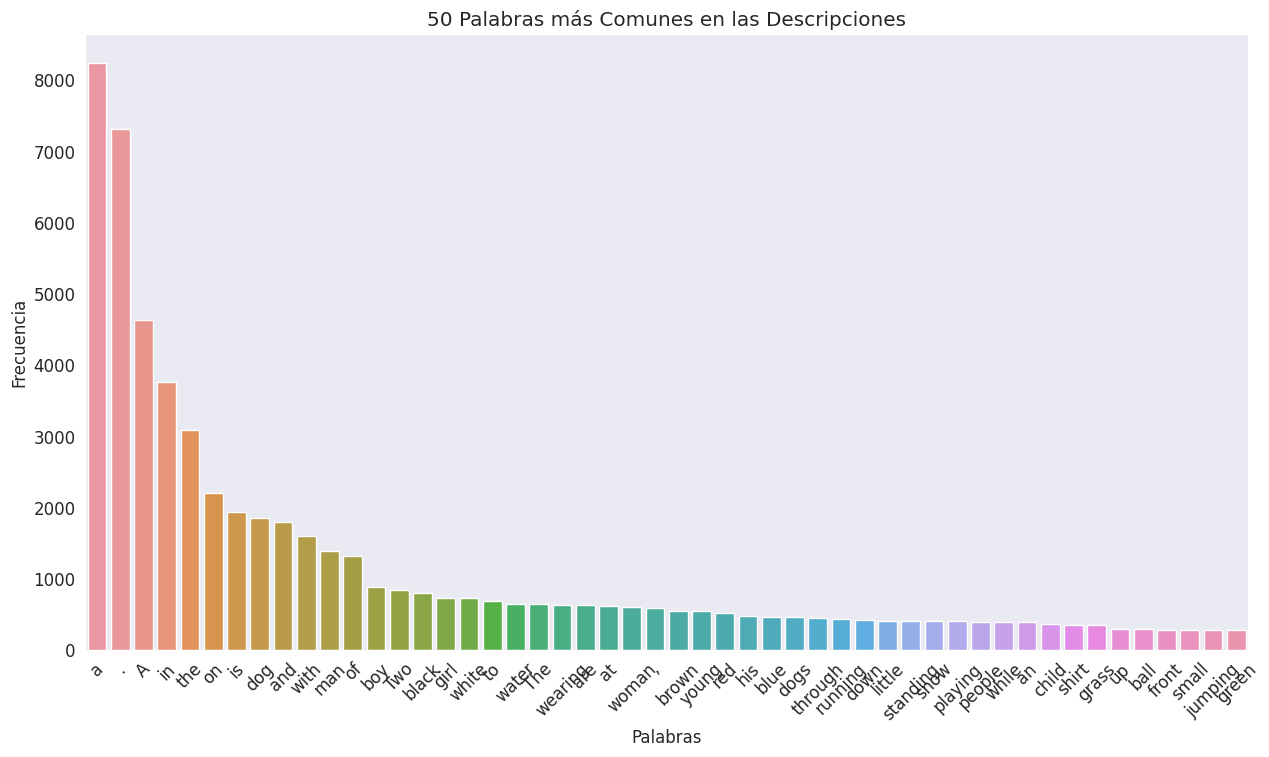

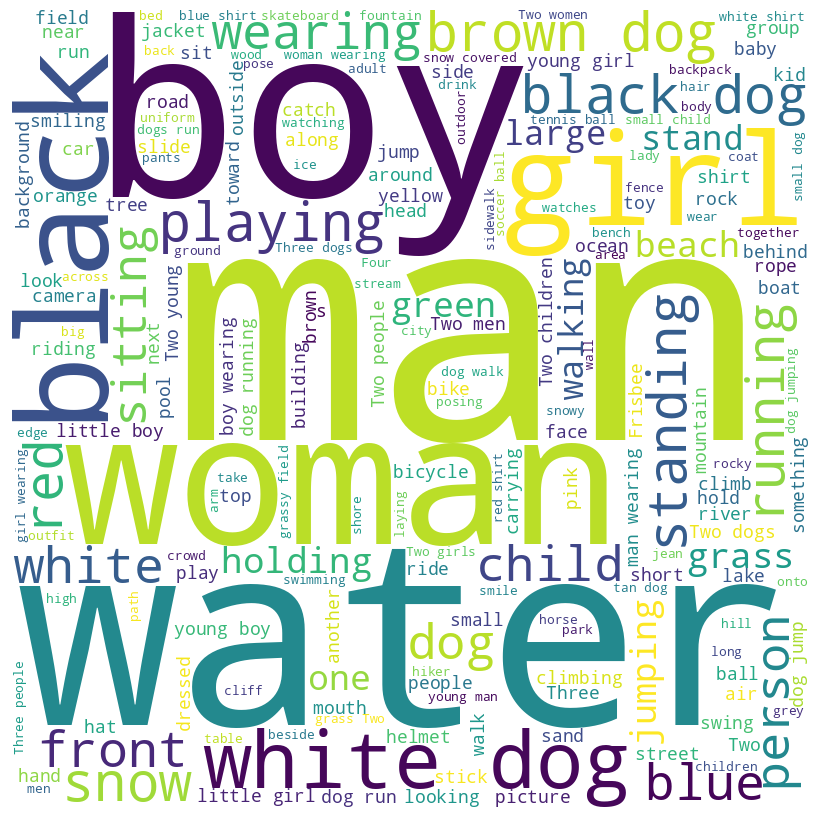

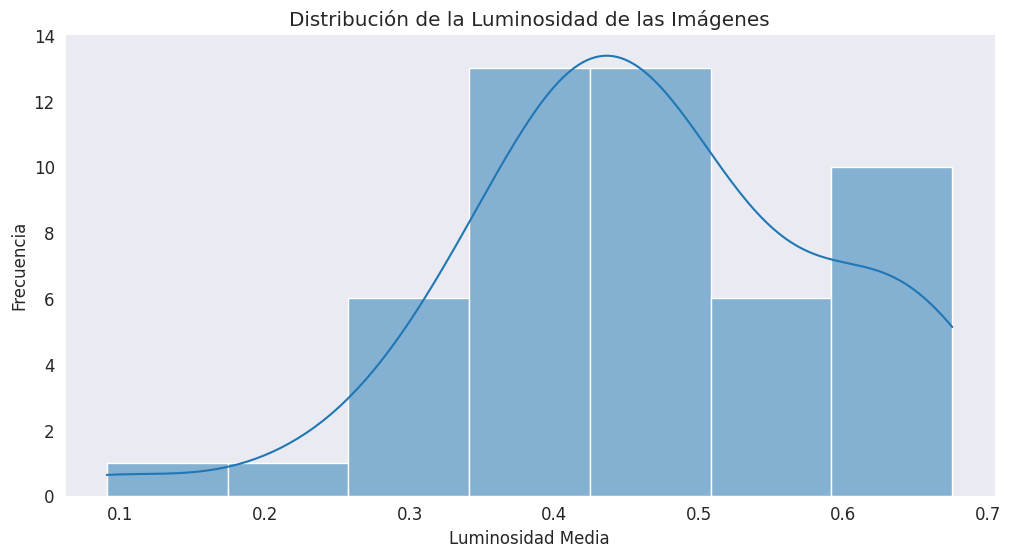

In [5]:
# ANÁLISIS EXPLORATORIO DE DATOS

from wordcloud import WordCloud, STOPWORDS

# Análisis de Texto

# Longitud de las descripciones
data['caption_length'] = data['caption'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 6))
sns.histplot(data['caption_length'], kde=True)
plt.title('Distribución de la Longitud de las Descripciones')
plt.xlabel('Longitud de la Descripción')
plt.ylabel('Frecuencia')
plt.show()

# Palabras más comunes en las descripciones
from collections import Counter
all_words = ' '.join(data['caption']).split()
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(50)
plt.figure(figsize=(15, 8))
sns.barplot(x=[word[0] for word in most_common_words], y=[word[1] for word in most_common_words])
plt.xticks(rotation=45)
plt.title('50 Palabras más Comunes en las Descripciones')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.show()

# Análisis de frecuencia de palabras específicas
wordcloud = WordCloud(width = 800, height = 800,
                      background_color ='white',
                      stopwords = set(STOPWORDS),
                      min_font_size = 10).generate(' '.join(data['caption']))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# Análisis de Imágenes

# Función para calcular la luminosidad media de una imagen
def get_image_brightness(img):
    # Convertir a escala de grises para simplificar el cálculo
    gray_img = tf.image.rgb_to_grayscale(img)
    brightness = np.mean(gray_img)
    return brightness

# Calcular y graficar la luminosidad media de un conjunto de imágenes
brightness_values = []
for img_name in data['image'].unique()[:50]:
    img = readImage(image_path + '/' + img_name)
    brightness = get_image_brightness(img)
    brightness_values.append(brightness)

plt.figure(figsize=(12, 6))
sns.histplot(brightness_values, kde=True)
plt.title('Distribución de la Luminosidad de las Imágenes')
plt.xlabel('Luminosidad Media')
plt.ylabel('Frecuencia')
plt.show()

In [6]:
# PREPROCESAMIENTO y CREA LOS CONJUNTOS DE ENTRENAMIENTO Y VALIDACION

def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]", ""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+", " "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    data['caption'] = "startseq " + data['caption'] + " endseq"
    return data

# Procesar los textos (captions)
data = text_preprocessing(data)
captions = data['caption'].tolist()
print(captions[:10])

# Crear y ajustar el Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

# Preparar los datos de las imágenes
images = data['image'].unique().tolist()
nimages = len(images)

# Dividir los datos en conjuntos de entrenamiento y validación
split_index = round(0.85 * nimages)
train_images = images[:split_index]
val_images = images[split_index:]

# Crear los conjuntos de datos de entrenamiento y validación
train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

# Ejemplo de cómo convertir texto a secuencias
print(tokenizer.texts_to_sequences([captions[1]])[0])


['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq', 'startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tri-colored dog playing with each other on the road endseq', 'startseq black dog and white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq']
[1, 15, 361, 54, 183, 154, 2]


In [7]:
# Image Feature Extraction

# Crear el modelo de extracción de características
model = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

# Tamaño de las imágenes
img_size = 224

# Diccionario para almacenar las características
features = {}

# Procesar las imágenes y extraer características
# 'data' contiene solo el 20% de las imágenes
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

# En este punto, 'features' contiene las características extraídas de las imágenes reducidas al 20%

74836368/74836368 [==============================] - 5s 0us/step


100%|██████████| 1618/1618 [02:31<00:00, 10.70it/s]


In [10]:
# MODELLING

# Definir la arquitectura del modelo
# Ajusta la forma de entrada de acuerdo con la forma de tus características de imagen 'X1'
input1 = Input(shape=(7, 7, 1920))
input2 = Input(shape=(max_length,))  # 'max_length' debe ser definido en tu entorno

# Procesar características de imagen
img_features = GlobalAveragePooling2D()(input1)  # Reduce la dimensión de las características de la imagen
img_features = Dense(256, activation='relu')(img_features)

# Procesar características del texto
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
sentence_features = LSTM(256)(sentence_features)
sentence_features = Dropout(0.5)(sentence_features)

# Combinar las características de imagen y texto
merged_features = add([sentence_features, img_features])
merged_features = Dense(128, activation='relu')(merged_features)
merged_features = Dropout(0.5)(merged_features)
output = Dense(vocab_size, activation='softmax')(merged_features)  # 'vocab_size' debe ser definido en tu entorno

# Crear el modelo
caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

# Ahora tu modelo 'caption_model' está listo para ser entrenado con los datos.

In [11]:
# DATA GENERATION

class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features, shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self, batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

In [12]:
# MODIFICACION DEL MODELO

# Visualización del modelo
plot_model(caption_model, to_file='caption_model.png')  # Guarda la visualización del modelo
caption_model.summary()  # Muestra un resumen del modelo

# Crear generadores de datos
train_generator = CustomDataGenerator(df=train, X_col='image', y_col='caption', batch_size=64, directory=image_path,
                                      tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

validation_generator = CustomDataGenerator(df=test, X_col='image', y_col='caption', batch_size=64, directory=image_path,
                                           tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

# Configurar los callbacks
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

# En este punto, tu modelo 'caption_model' y los generadores de datos están listos para ser utilizados en el entrenamiento.

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 34, 256)              1031424   ['input_3[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 7, 7, 1920)]         0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 256)                  525312    ['embedding[0][0]']           
                                                                                            

In [13]:
# Modelo 2

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, add, GlobalAveragePooling2D

# Definir la arquitectura del modelo simplificado
input1_simplificado = Input(shape=(7, 7, 1920))
input2_simplificado = Input(shape=(max_length,))

# Procesar características de imagen (más simplificado)
img_features_simplificado = GlobalAveragePooling2D()(input1_simplificado)
img_features_simplificado = Dense(128, activation='relu')(img_features_simplificado)

# Procesar características del texto (más simplificado)
sentence_features_simplificado = Embedding(vocab_size, 128, mask_zero=True)(input2_simplificado)
sentence_features_simplificado = LSTM(128)(sentence_features_simplificado)
sentence_features_simplificado = Dropout(0.5)(sentence_features_simplificado)

# Combinar las características de imagen y texto
merged_features_simplificado = add([sentence_features_simplificado, img_features_simplificado])
merged_features_simplificado = Dense(64, activation='relu')(merged_features_simplificado)
output_simplificado = Dense(vocab_size, activation='softmax')(merged_features_simplificado)

# Crear el modelo simplificado
caption_model_simplificado = Model(inputs=[input1_simplificado, input2_simplificado], outputs=output_simplificado)
caption_model_simplificado.compile(loss='categorical_crossentropy', optimizer='adam')

# Resumen del modelo simplificado
caption_model_simplificado.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 34, 128)              515712    ['input_5[0][0]']             
                                                                                                  
 input_4 (InputLayer)        [(None, 7, 7, 1920)]         0         []                            
                                                                                                  
 lstm_1 (LSTM)               (None, 128)                  131584    ['embedding_1[0][0]']         
                                                                                            

In [14]:
#ENTRENAMIENTO DEL MODELO

history = caption_model.fit(
    train_generator,
    epochs=10,  # número de épocas
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction])


Epoch 1/10
107/107 [==============================] - ETA: 0s - loss: 5.9952
Epoch 1: val_loss improved from inf to 5.27731, saving model to model.h5
107/107 [==============================] - 201s 2s/step - loss: 5.9952 - val_loss: 5.2773 - lr: 0.0010
Epoch 2/10
107/107 [==============================] - ETA: 0s - loss: 5.0686
Epoch 2: val_loss improved from 5.27731 to 4.65438, saving model to model.h5
107/107 [==============================] - 45s 424ms/step - loss: 5.0686 - val_loss: 4.6544 - lr: 0.0010
Epoch 3/10
107/107 [==============================] - ETA: 0s - loss: 4.5573
Epoch 3: val_loss improved from 4.65438 to 4.36683, saving model to model.h5
107/107 [==============================] - 45s 420ms/step - loss: 4.5573 - val_loss: 4.3668 - lr: 0.0010
Epoch 4/10
107/107 [==============================] - ETA: 0s - loss: 4.2447
Epoch 4: val_loss improved from 4.36683 to 4.23776, saving model to model.h5
107/107 [==============================] - 45s 420ms/step - loss: 4.2447 - 

In [15]:
# Entrenamiento del Modelo Simplificado

# Configurar los callbacks para el modelo simplificado
model_name_simplificado = "modelo_simplificado.h5"
checkpoint_simplificado = ModelCheckpoint(model_name_simplificado,
                                          monitor="val_loss",
                                          mode="min",
                                          save_best_only=True,
                                          verbose=1)

earlystopping_simplificado = EarlyStopping(monitor='val_loss',
                                           min_delta=0,
                                           patience=5,
                                           verbose=1,
                                           restore_best_weights=True)

learning_rate_reduction_simplificado = ReduceLROnPlateau(monitor='val_loss',
                                                         patience=3,
                                                         verbose=1,
                                                         factor=0.2,
                                                         min_lr=0.00000001)

# Entrenar el modelo sencillo
history_simplificado = caption_model_simplificado.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint_simplificado, earlystopping_simplificado, learning_rate_reduction_simplificado])

Epoch 1/10
107/107 [==============================] - ETA: 0s - loss: 5.8861
Epoch 1: val_loss improved from inf to 5.25117, saving model to modelo_simplificado.h5
107/107 [==============================] - 52s 438ms/step - loss: 5.8861 - val_loss: 5.2512 - lr: 0.0010
Epoch 2/10
107/107 [==============================] - ETA: 0s - loss: 5.0025
Epoch 2: val_loss improved from 5.25117 to 4.86085, saving model to modelo_simplificado.h5
107/107 [==============================] - 45s 422ms/step - loss: 5.0025 - val_loss: 4.8608 - lr: 0.0010
Epoch 3/10
107/107 [==============================] - ETA: 0s - loss: 4.4573
Epoch 3: val_loss improved from 4.86085 to 4.57052, saving model to modelo_simplificado.h5
107/107 [==============================] - 46s 427ms/step - loss: 4.4573 - val_loss: 4.5705 - lr: 0.0010
Epoch 4/10
107/107 [==============================] - ETA: 0s - loss: 4.0257
Epoch 4: val_loss improved from 4.57052 to 4.41610, saving model to modelo_simplificado.h5
107/107 [========

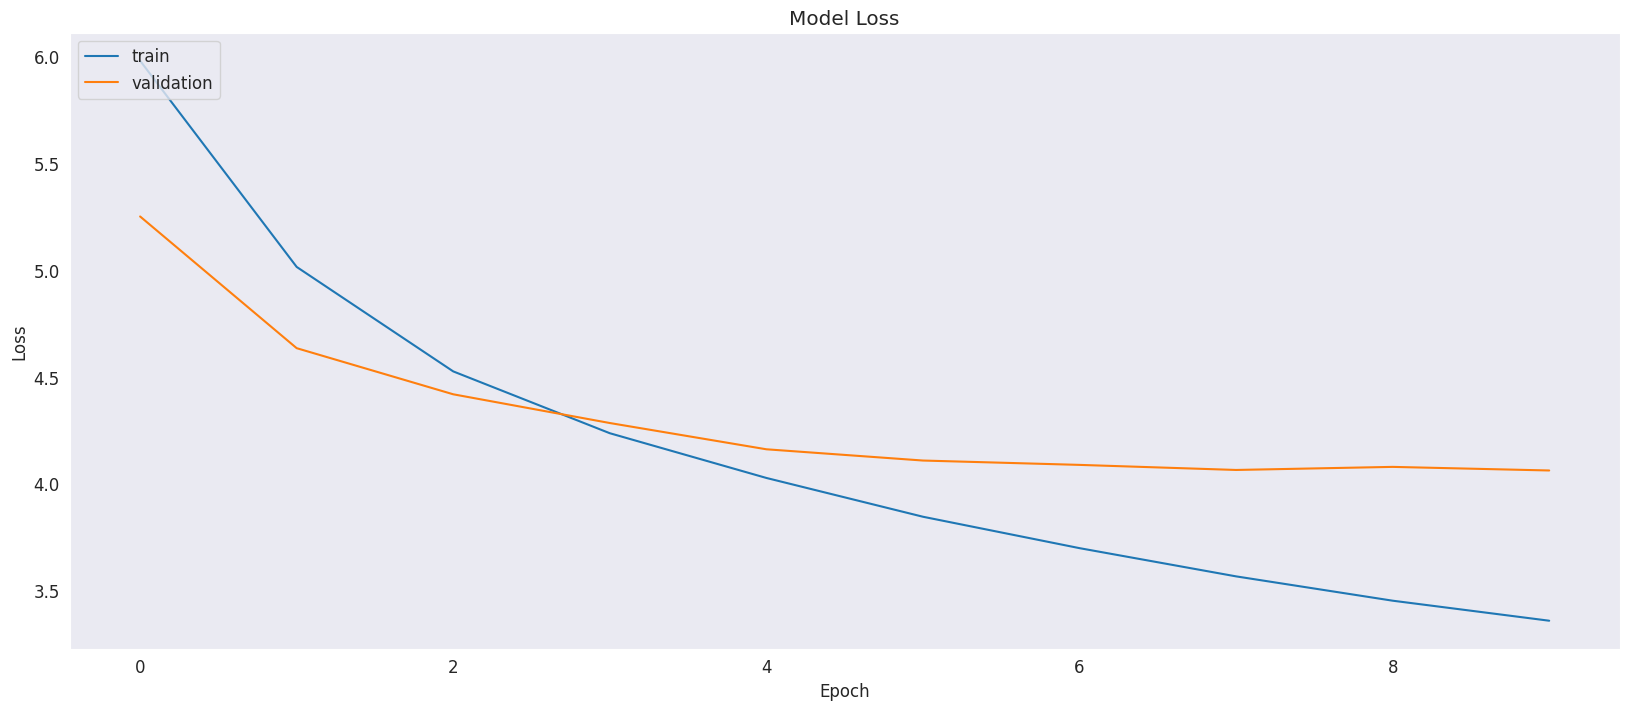

In [ ]:


# Graficar la pérdida del modelo
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


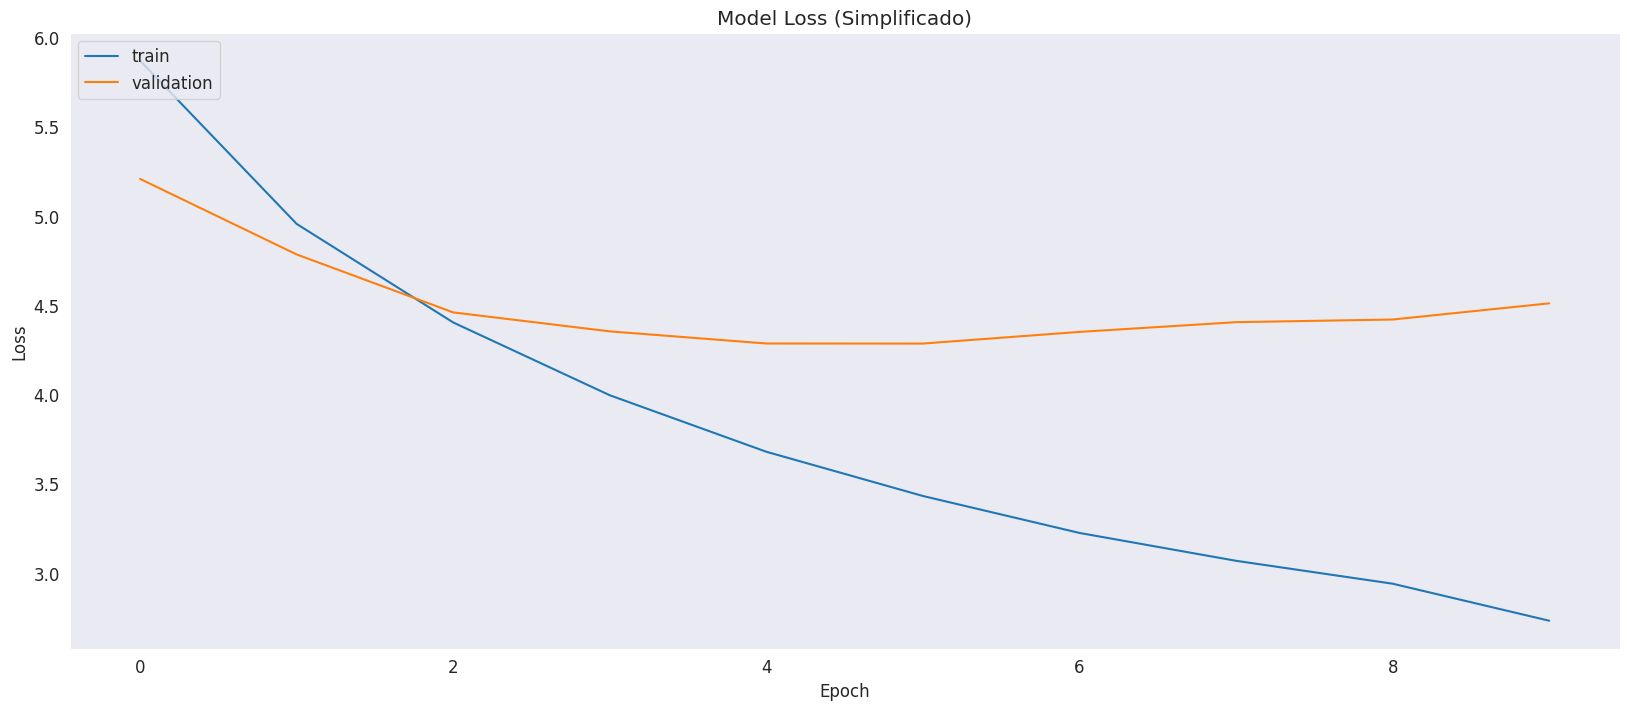

In [ ]:
# Graficar la pérdida del modelo simplificado
plt.figure(figsize=(20, 8))
plt.plot(history_simplificado.history['loss'], label='train')
plt.plot(history_simplificado.history['val_loss'], label='validation')
plt.title('Model Loss (Simplificado)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#Caption Generation

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length, features):
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        y_pred = model.predict([feature, sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)
        if word is None:
            break

        in_text += " " + word
        if word == 'endseq':
            break

    return in_text

# Uso de la función predict_caption (asegúrate de que 'model', 'tokenizer', 'max_length' y 'features' estén definidos)
# Ejemplo: predicted_caption = predict_caption(model, 'image_name.jpg', tokenizer, max_length, features)


1/1 [==============================] - 0s 25ms/step


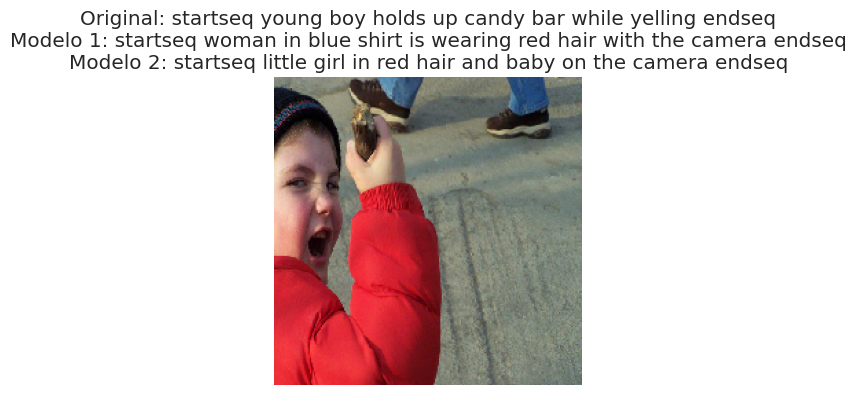

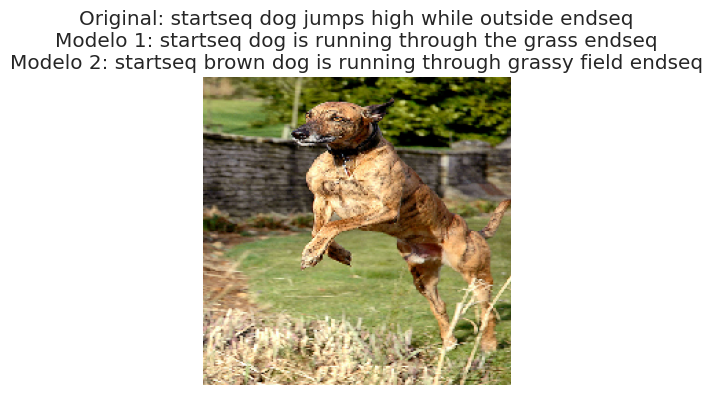

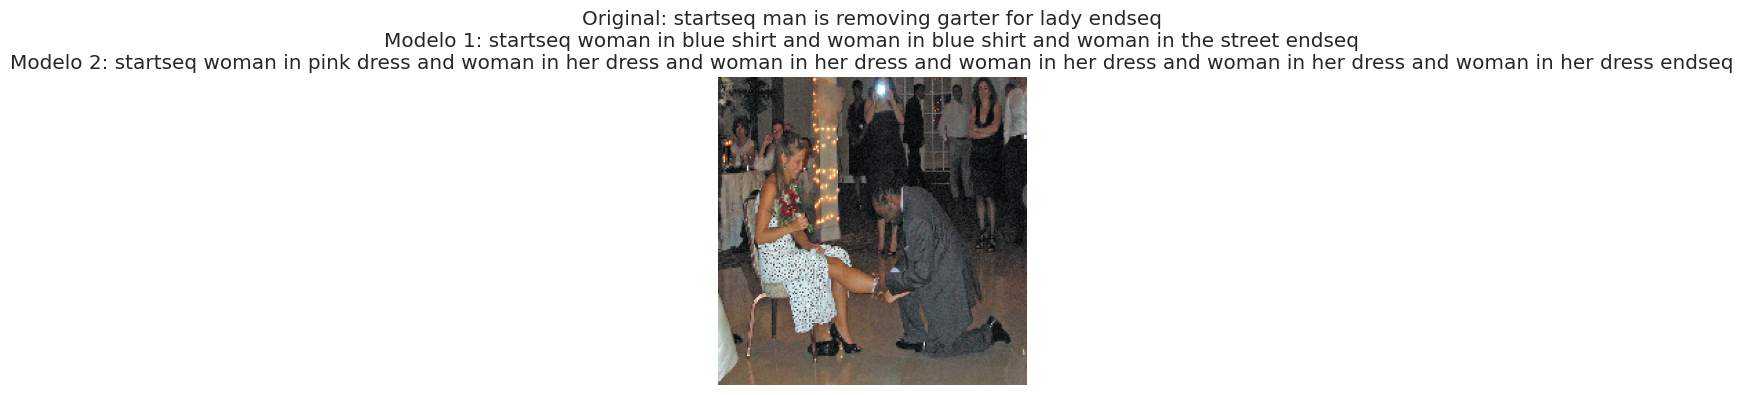

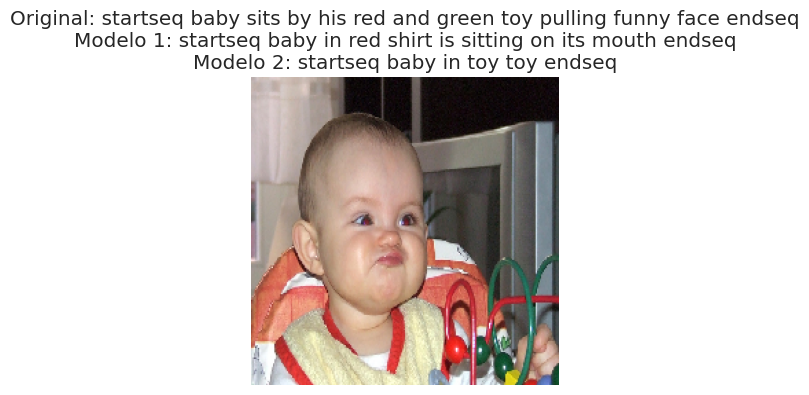

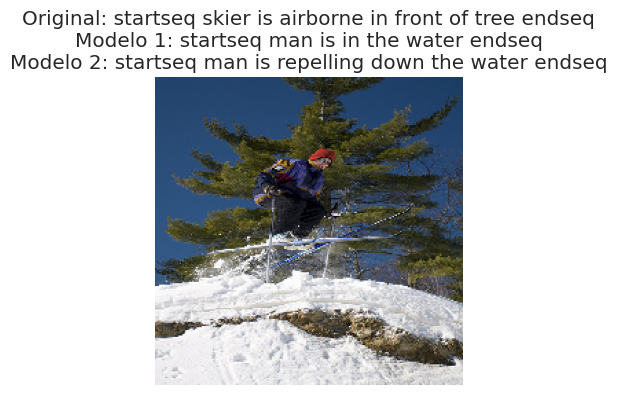

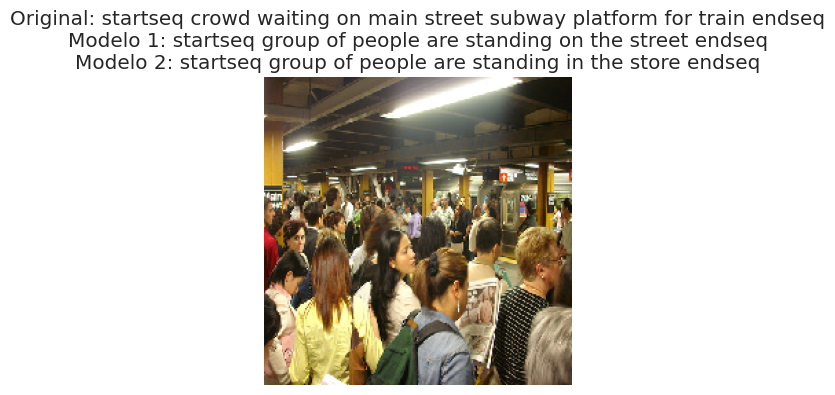

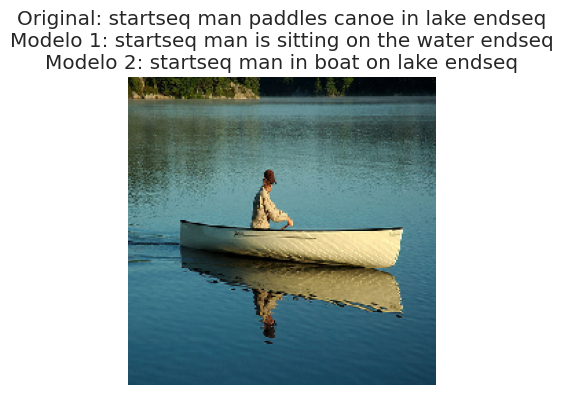

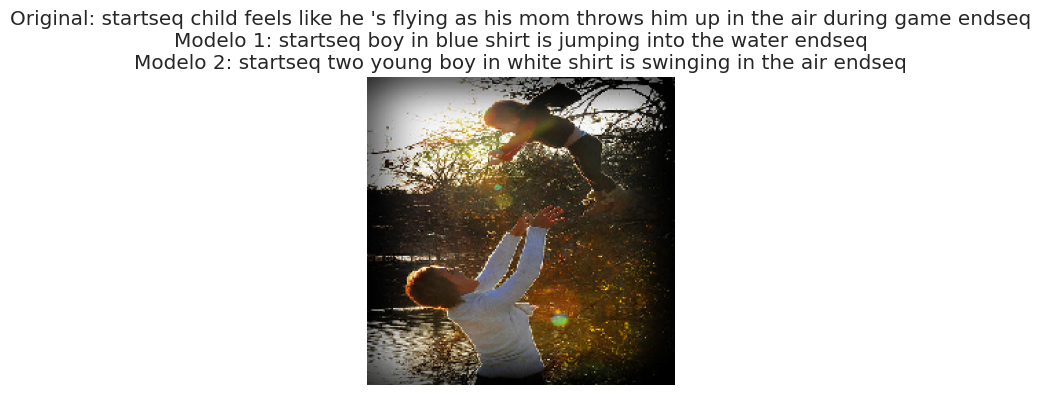

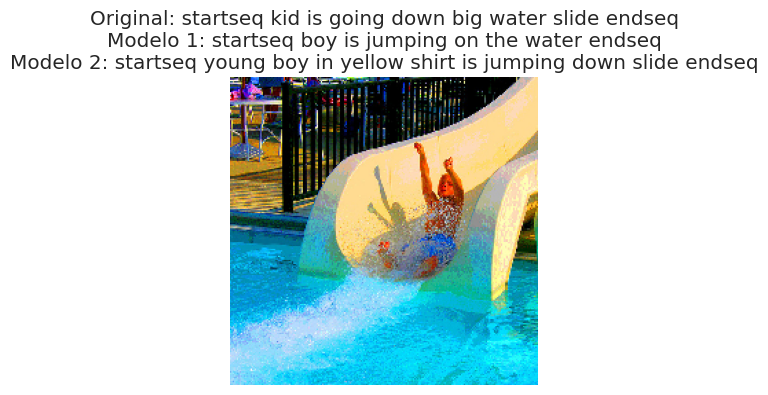

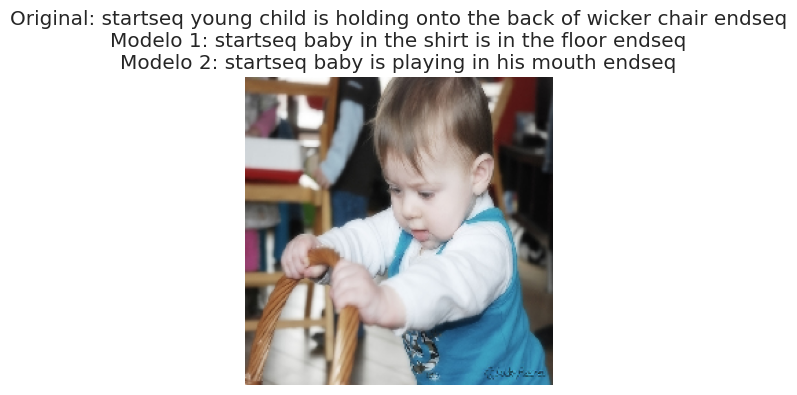

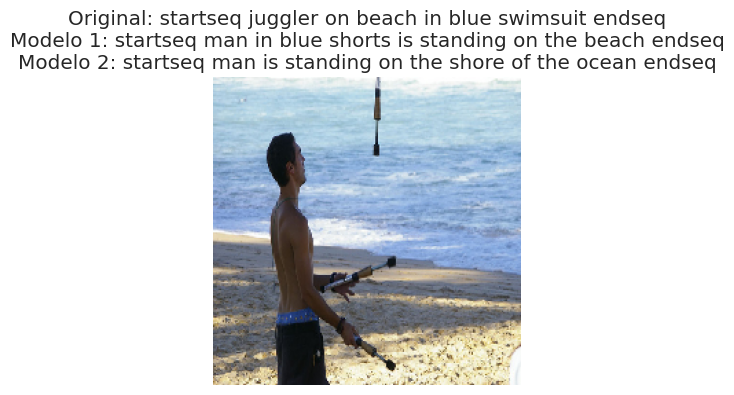

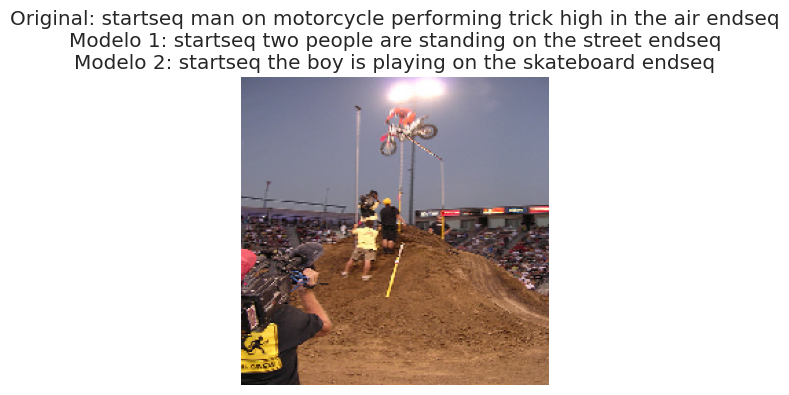

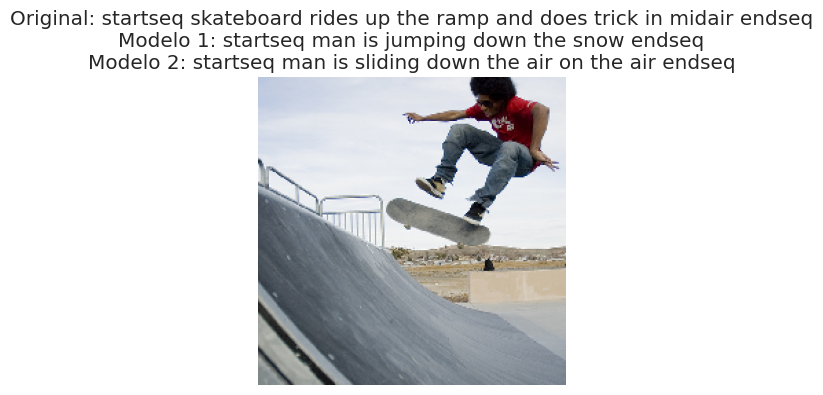

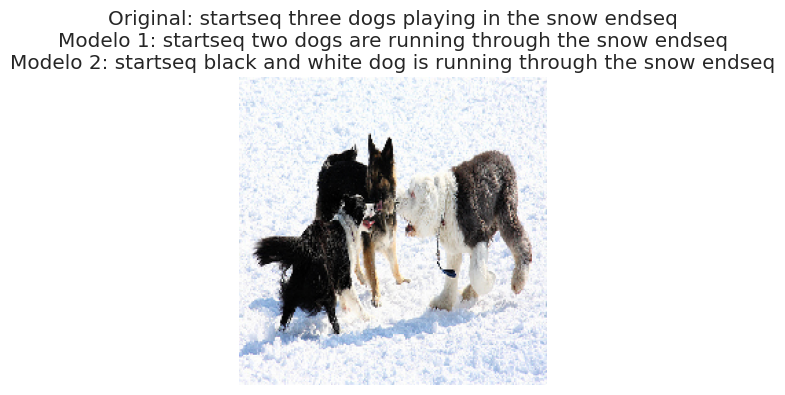

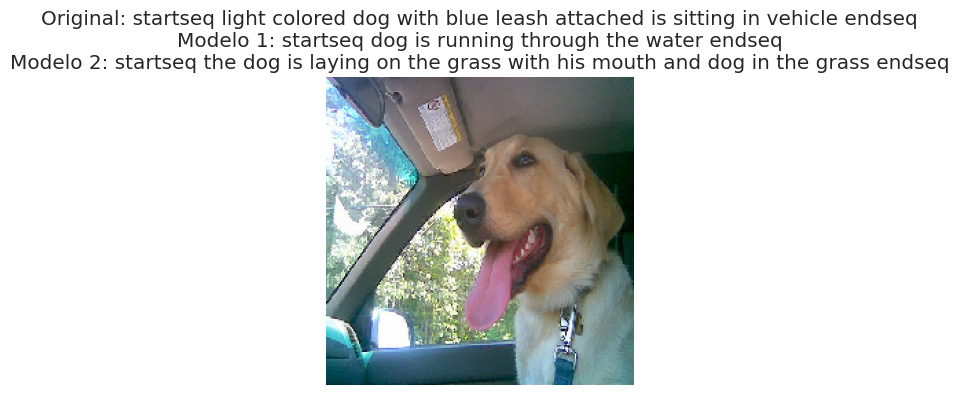

In [ ]:
#Muestreo aleatorio para image captioning

# Aplicar el código a ambos modelos

samples = test.sample(15)
samples.reset_index(drop=True, inplace=True)

for index, record in samples.iterrows():
    img = load_img(os.path.join(image_path, record['image']), target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.

    # Generar subtítulo con el primer modelo
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index, 'caption_model'] = caption

    # Generar subtítulo con el modelo simplificado
    caption_simplificado = predict_caption(caption_model_simplificado, record['image'], tokenizer, max_length, features)
    samples.loc[index, 'caption_model_simplificado'] = caption_simplificado

# Función para mostrar una sola imagen por fila con subtítulos
def display_images_with_captions(df):
    for i in range(len(df)):
        plt.figure(figsize=(5, 4))  # tamaño de la figura

        # Mostrar imagen
        img = load_img(os.path.join(image_path, df.iloc[i]['image']), target_size=(224, 224))
        plt.imshow(img)
        plt.axis('off')

        # Mostrar subtítulos
        plt.title(f"Original: {df.iloc[i]['caption']}\nModelo 1: {df.iloc[i]['caption_model']}\nModelo 2: {df.iloc[i]['caption_model_simplificado']}")
        plt.show()

# Mostrar las imágenes con subtítulos
display_images_with_captions(samples)

In [ ]:
#Guarda el modelo en mi Google Drive

from google.colab import drive
drive.mount('/content/drive')

# Guarda el modelo en una carpeta específica de Google Drive
model.save('/content/drive/My Drive/ColabData/ProyectoModulo6/mi_modelo_entrenado.h5')

Mounted at /content/drive


In [ ]:
!pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from nltk.tokenize import word_tokenize

# Función para calcular el BLEU score
def calculate_bleu(data, model, tokenizer, max_length, features):
    actual, predicted = [], []
    for idx in range(len(data)):
        reference = data.iloc[idx]['caption']
        image_id = data.iloc[idx]['image']

        # Generar subtítulo
        yhat = predict_caption(model, image_id, tokenizer, max_length, features)

        # Tokenizar las frases
        reference_tokens = word_tokenize(reference.lower())
        yhat_tokens = word_tokenize(yhat.split('startseq ')[1].split(' endseq')[0].lower())

        actual.append([reference_tokens])
        predicted.append(yhat_tokens)

    # Calcular BLEU score
    score = corpus_bleu(actual, predicted)
    return score

# Calcular BLEU para el primer modelo
bleu_score_model_1 = calculate_bleu(test, caption_model, tokenizer, max_length, features)

# Calcular BLEU para el modelo simplificado
bleu_score_model_2 = calculate_bleu(test, caption_model_simplificado, tokenizer, max_length, features)

print(f"BLEU score para el primer modelo: {bleu_score_model_1}")
print(f"BLEU score para el modelo simplificado: {bleu_score_model_2}")


Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 23ms/step
BLEU score para el primer modelo: 0.022740541385519286
BLEU score para el modelo simplificado: 0.009111110063993637


In [ ]:
#Calcular METEOR Score
import nltk
nltk.download('wordnet')

def calculate_meteor(data, model, tokenizer, max_length, features):
    scores = []
    for idx in range(len(data)):
        reference = data.iloc[idx]['caption']
        image_id = data.iloc[idx]['image']
        yhat = predict_caption(model, image_id, tokenizer, max_length, features)

        # Tokenizar las frases
        reference_tokens = word_tokenize(reference.lower())
        yhat_tokens = word_tokenize(yhat.split('startseq ')[1].split(' endseq')[0].lower())

        # Calcular METEOR score
        score = meteor_score([reference_tokens], yhat_tokens)
        scores.append(score)

    # Calcular el promedio de los scores
    return sum(scores) / len(scores)

# Calcular METEOR para ambos modelos
meteor_score_model_1 = calculate_meteor(test, caption_model, tokenizer, max_length, features)
meteor_score_model_2 = calculate_meteor(test, caption_model_simplificado, tokenizer, max_length, features)

print(f"METEOR score para el primer modelo: {meteor_score_model_1}")
print(f"METEOR score para el modelo simplificado: {meteor_score_model_2}")




1/1 [==============================] - 0s 23ms/step


[nltk_data] Downloading package wordnet to /root/nltk_data...


Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 27ms/step
METEOR score para el primer modelo: 0.15366109893445237
METEOR score para el modelo simplificado: 0.12801399010458697


In [ ]:
#Calcular el ROUGE Score

!pip install rouge

from rouge import Rouge

def calculate_rouge(data, model, tokenizer, max_length, features):
    rouge = Rouge()
    actual, predicted = [], []

    for idx in range(len(data)):
        reference = data.iloc[idx]['caption']
        image_id = data.iloc[idx]['image']
        yhat = predict_caption(model, image_id, tokenizer, max_length, features)

        # Extraer subtítulos generados sin los tokens 'startseq' y 'endseq'
        yhat_clean = yhat.split('startseq ')[1].split(' endseq')[0]

        actual.append(reference)
        predicted.append(yhat_clean)

    # Calcular ROUGE score
    scores = rouge.get_scores(predicted, actual, avg=True)
    return scores

# Calcular ROUGE para ambos modelos
rouge_score_model_1 = calculate_rouge(test, caption_model, tokenizer, max_length, features)
rouge_score_model_2 = calculate_rouge(test, caption_model_simplificado, tokenizer, max_length, features)

print("ROUGE score para el primer modelo:", rouge_score_model_1)
print("ROUGE score para el modelo simplificado:", rouge_score_model_2)


Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 26ms/step
ROUGE score para el primer modelo: {'rouge-1': {'r': 0.18939562212982747, 'p': 0.2936334835717554, 'f': 0.2255258990492291}, 'rouge-2': {'r': 0.05124587456764593, 'p': 0.08266228513142113, 'f': 0.06189508074669234}, 'rouge-l': {'r': 0.1810885637937205, 'p': 0.2794049252073942, 'f': 0.21529269087500583}}
ROUGE score para el modelo simplificado: {'rouge-1': {'r': 0.17217941279899043, 'p': 0.3171755176693445, 'f': 0.21593015043175473}, 'rouge-2': {'r': 0.04035541635138405, 'p': 0.06920406296949515, 'f': 0.0494606192245735}, 'rouge-l': {'r': 0.16510388761296568, 'p': 0.30361062120321347, 'f': 0.20682518404332337}}
